## Cao Nguyễn Gia Hưng
## 20089711

In [3]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
import os
import json

### Tiền xử lý dữ liệu với Beautiful Soup, re,..

In [2]:
url_base = 'https://vnexpress.net'
headers = ['the-thao', 'khoa-hoc', 'suc-khoe', 'giao-duc', 'du-lich']

In [ ]:
url_subpage =[]
for header in headers:
    url_post = []
    
    for page in range(1,10):
        response = requests.get(url_base+'/'+header+'-p'+str(page))
        soup = BeautifulSoup(response.text, 'html.parser')
        posts = soup.find_all(class_='title-news')
        for post in posts:
            url_post.append(post.a['href'])
    url_subpage.append({
        header: list(set(url_post))
    })

In [ ]:
with open('url.json', 'w') as f:
    json.dump(url_subpage, f, indent=4)

In [ ]:
len(url_subpage[1]['khoa-hoc'])

275

In [ ]:
%%bash
rm -r data

In [ ]:
os.makedirs('./data')

In [ ]:
rag = tqdm(url_subpage)
for urls in rag:
    header =list(urls.keys())[0]
    url_post = list(urls.values())[0]
    json_result = []
    while len(json_result) <250 and url_post:
        rag.set_description(f'{header} - {len(json_result)}')
        url = url_post.pop()
        response = requests.get(url)
        try:
            soup = BeautifulSoup(response.text, 'html.parser')
            title = soup.find(class_='title-detail').text
            description = soup.find('p', class_='description')
            for i in description.find_all(class_='location-stamp'):
                i.decompose()
            description = description.text
            content = '\n'.join([p.text for p in soup.find_all('p', class_='Normal')])
            title_ = re.sub(r'[^a-zA-Z]+', '', title).lower()
            content = description+'\n'+content
            if len(content) < 1000:
                continue
            json_result.append({
                'title': title,
                'content': description+'\n'+content,
            })
        except AttributeError:
            print('Error')
            continue
        
    with open(f'./data/{header}.json', 'w') as f:
        json.dump(json_result, f, ensure_ascii=False, indent=4)
        

Loads data

In [5]:
files = os.listdir('./data')
paths = [file for file in files if file.endswith('.json')]

In [8]:
data = []
labels = []
for path in paths:
    with open( os.path.join('./data', path), 'r') as f:
        doc = json.load(f)
        for item in doc:
            data.append(item['content'])
            labels.append(path.split('.')[0])        

### 2. Tách từ (Tokenize) sử dụng thư viện pyvi hay underthesea

In [107]:
from underthesea import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

Tiền xử lý dữ liệu

In [108]:
df = pd.DataFrame({'data': data, 'label': labels})

In [109]:
df['text'] = df['data'].apply(lambda x: x.lower())

In [110]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()

In [111]:
df['label_encode'] = lb.fit_transform(df['label'])

#### Tách từ (Tokenize) sử dụng thư viện pyvi hay underthesea

In [112]:
df['text'] = df['text'].apply(lambda x: word_tokenize(x, format="text"))

In [12]:
# from nltk.corpus import stopwords

# # Lấy danh sách stop words tiếng Việt
# stop_words = set(stopwords.words('vietnamese'))

In [13]:
# def process(text):
#     text = word_tokenize(text, format="text")
#     text = [word for word in text.split() if word not in stop_words]
#     return ' '.join(text)

In [14]:
# df['text'] = df['text'].apply(lambda x: process(x))

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    1235 non-null   object
 1   label   1235 non-null   object
 2   text    1235 non-null   object
dtypes: object(3)
memory usage: 29.1+ KB


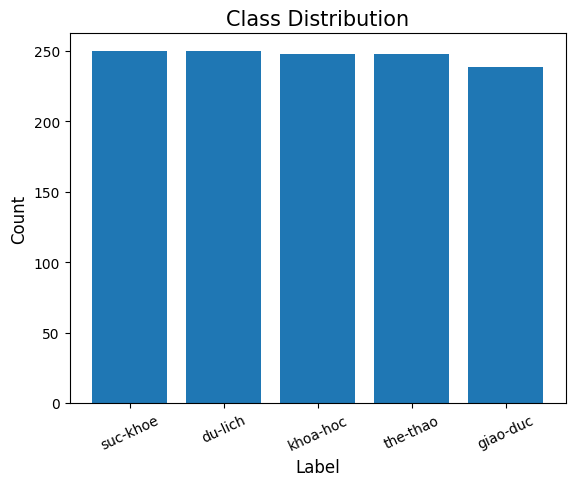

In [32]:
# visualize class distribution
plt.bar(df.label.value_counts().index, df.label.value_counts())
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=25)
plt.title('Class Distribution', fontsize=15)
plt.show()

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#### Chia văn bản với tỉ lệ 8:2

In [73]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label_encode'], test_size=.2, random_state=42)
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

### Trích xuất đặc trưng TF-IDF bằng thư viện sklearn

In [74]:
tfidf_vectorizer = TfidfVectorizer(max_features=5500)
tfidf_vectorizer.fit(df['text'])

X_train_idf = tfidf_vectorizer.transform(X_train)
X_test_idf = tfidf_vectorizer.transform(X_test)

### Đánh giá bộ dữ liệu với giải thuật KNN bằng phương pháp 5-Fold (k-fold)

In [75]:
knn= KNeighborsClassifier(n_neighbors=10)
kf= KFold(n_splits=5, shuffle=True, random_state=42)
scores= cross_val_score(knn, X=X_train_idf, y=y_train, cv=kf)

In [76]:
print(scores)
print(scores.mean())

[0.95454545 0.94949495 0.96969697 0.96446701 0.95939086]
0.9595190483515357


#### Huấn luyện dữ liệu cho bài toán phân loại văn bản sử dụng đặc trưng TF-IDF và giải thuật SVM. 

In [77]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

In [82]:

svm_model = SVC()
svm_model.fit(X_train_idf.toarray(), y_train)

# Đánh giá mô hình
y_pred = svm_model.predict(X_test_idf.toarray())
accuracy_svc = accuracy_score(y_test, y_pred)
confusion_svc = confusion_matrix(y_test, y_pred)
f1_score_svm = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy_svc)
print("F1 score:", f1_score_svm)
print("Confusion Matrix:\n", confusion_svc)

Accuracy: 0.97165991902834
F1 score: 0.9718775148881378
Confusion Matrix:
 [[43  0  1  0  0]
 [ 0 54  1  0  0]
 [ 1  0 49  1  0]
 [ 0  0  3 46  0]
 [ 0  0  0  0 48]]


#### Huấn luyện dữ liệu cho bài toán phân loại văn bản sử dụng đặc trưng TF-IDF và giải thuật Bayes. 

In [79]:
from sklearn.naive_bayes import GaussianNB

In [84]:
bayes_model = GaussianNB()
bayes_model.fit(X_train_idf.toarray(), y_train)

y_pred = bayes_model.predict(X_test_idf.toarray())
accuracy_gb = accuracy_score(y_test, y_pred)
confusion_gb = confusion_matrix(y_test, y_pred)
f1_score_gb = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy_gb)
print("F1 score:", f1_score_gb)
print("Confusion Matrix:\n", confusion_gb)

Accuracy: 0.8866396761133604
F1 score: 0.8844585246616772
Confusion Matrix:
 [[39  1  3  0  1]
 [ 1 52  1  0  1]
 [ 5  7 36  3  0]
 [ 2  0  1 45  1]
 [ 1  0  0  0 47]]


### So sánh kết quả các độ đo 6,7,8 với 2 giải thuật học máy ở trên

In [98]:
import warnings
warnings.filterwarnings('ignore')

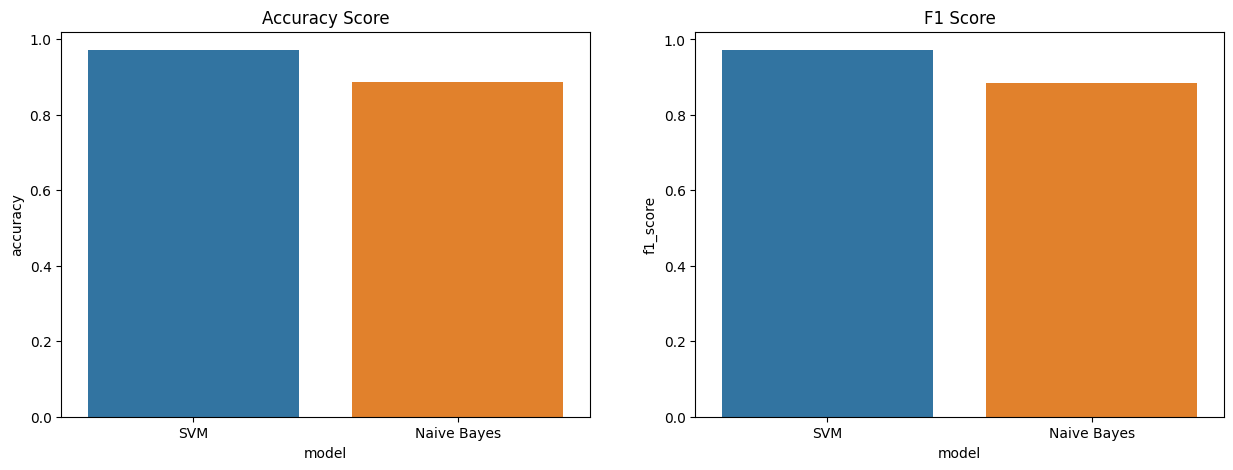

In [99]:
df = pd.DataFrame({'model': ['SVM', 'Naive Bayes'], 'accuracy': [accuracy_svc, accuracy_gb],
                   'f1_score': [f1_score_svm, f1_score_gb]})
# visualize model 
# subplot 2
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(x='model', y='accuracy', data=df, ax=ax[0])
ax[0].set_title('Accuracy Score')
sns.barplot(x='model', y='f1_score', data=df, ax=ax[1])
ax[1].set_title('F1 Score')
plt.show();

In [61]:
from sklearn.pipeline import Pipeline

In [62]:
from sklearn.base import BaseEstimator, TransformerMixin

In [63]:

class ProcessText(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, list):
            return self.process(X)
        return self.process([X])
        return processed_text
    def process(self, text):
        for t in text:
            t = t.lower()
            t = word_tokenize(t, format="text")
        return tfidf_vectorizer.transform(text).toarray()


In [64]:
pipeline_predict = Pipeline([
    ('process', ProcessText()),
    ('model', svm_model)
])


predicted_class = pipeline_predict.predict("""Năm nay, hơn 660.000 thí sinh đăng ký xét tuyển đại học với 3,4 triệu nguyện vọng. Ngay sau khi kết thúc thời gian nhập học, các trường chưa tuyển đủ được tuyển bổ sung đến tháng 12.
""")
lb.inverse_transform(predicted_class)

array(['giao-duc'], dtype=object)

### Lưu model có kết quả tốt nhất

In [ ]:
# save model
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(pipeline_predict, f)
    
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(lb, f)

### Xây dựng ứng dụng phân loại văn bản với đầu vào là 1 văn bản bất kỳ có thể tự ngõ hay từ 1 file, in kết quả ra màn hình

In [119]:
%%bash
streamlit run app.py


  You can now view your Streamlit app in your browser.

  Network URL: http://192.168.1.25:8501
  External URL: http://113.172.60.17:8501

Error while terminating subprocess (pid=42344): 


Link deploy: https://nlpweek5.streamlit.app/

## Câu 2

In [7]:
from sklearn.feature_extraction.text import HashingVectorizer
corpus = [
 ' Hôm_nay tôi đi_học', 
 ' Hôm_nay tôi đi_học ở trường', 
 ' Hôm_nay tôi nghỉ ở nhà', 
 ' Hôm_nay tôi có đi_học không?',
]
vectorizer = HashingVectorizer(n_features=2**4)
X = vectorizer.fit_transform(corpus)
print(X.shape)


  (0, 340)	-0.5773502691896258
  (0, 397)	-0.5773502691896258
  (0, 451)	-0.5773502691896258
  (1, 282)	0.5
  (1, 340)	-0.5
  (1, 397)	-0.5
  (1, 451)	-0.5
  (2, 361)	0.5
  (2, 397)	-0.5
  (2, 448)	0.5
  (2, 451)	-0.5
  (3, 113)	0.4472135954999579
  (3, 340)	-0.4472135954999579
  (3, 352)	0.4472135954999579
  (3, 397)	-0.4472135954999579
  (3, 451)	-0.4472135954999579


> Nhận xét: <br>

Vector hóa và Hash Trick là hai phương pháp quan trọng trong tiền xử lý dữ liệu và biểu diễn đặc trưng cho các mô hình máy học: <br>
- Vector hóa:<br>
Vector hóa là quá trình biến đổi dữ liệu không cấu trúc thành các vectơ số học để có thể sử dụng cho các mô hình máy học. <br>
Phương pháp này thường được ưa chuộng khi kích thước từ vựng không quá lớn và có đủ bộ nhớ để lưu trữ toàn bộ đặc điểm.<br>
Có khả năng diễn giải cao, cho phép biết mỗi đặc điểm chiều tương ứng với từ nào và có thể sử dụng TF-IDF để cân nhắc trọng số của từng đặc điểm.<br>
- Hash Trick:<br>
Hash Trick là một trường hợp đặc biệt của vector hóa, thường được sử dụng trong các tình huống máy học quy mô lớn khi vốn từ vựng rất lớn và vector hóa truyền thống không đủ bộ nhớ.<br>
Phương pháp này sử dụng hàm hash để ánh xạ đặc điểm vào các vị trí trong vectơ có kích thước cố định.<br>
Hash Trick giúp giảm kích thước vectơ đặc trưng nhanh chóng và có thể vẫn đủ cho các nhiệm vụ tiếp theo, nhưng có thể làm mất một phần thông tin về ngữ nghĩa và không thể diễn giải như vector hóa truyền thống.<br>
- Sử dụng thích hợp:<br>
Sử dụng vector hóa chung khi kích thước từ vựng nhỏ và có đủ bộ nhớ. Nó giúp diễn giải và tinh chỉnh trọng số dễ dàng hơn.<br>
Sử dụng Hash Trick trong trường hợp máy học quy mô lớn khi không đủ bộ nhớ để lưu trữ vector đặc trưng toàn bộ từ vựng. Tuy nhiên, cần lưu ý rằng việc sử dụng Hash Trick có thể làm mất một phần thông tin ngữ nghĩa và không thể diễn giải các đặc điểm cụ thể.<br>
Tùy thuộc vào nhiệm vụ cụ thể và ràng buộc về tài nguyên, người ta có thể chọn giữa vector hóa và Hash Trick để biểu diễn dữ liệu một cách hiệu quả và phù hợp.<br>

## Câu 3

In [113]:
from sklearn.feature_extraction.text import HashingVectorizer
vectorizer = HashingVectorizer(n_features=999)
vectorizer.fit_transform(df['text'])

<1235x999 sparse matrix of type '<class 'numpy.float64'>'
	with 264863 stored elements in Compressed Sparse Row format>

In [114]:
X_train_hv = vectorizer.transform(X_train)
X_test_hv = vectorizer.transform(X_test)

In [116]:

svm_model = SVC()
svm_model.fit(X_train_hv, y_train)

# Đánh giá mô hình
y_pred = svm_model.predict(X_test_hv.toarray())
accuracy_svc = accuracy_score(y_test, y_pred)
confusion_svc = confusion_matrix(y_test, y_pred)
f1_score_svm = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy_svc)
print("F1 score:", f1_score_svm)
print("Confusion Matrix:\n", confusion_svc)

Accuracy: 0.9676113360323887
F1 score: 0.967817631680301
Confusion Matrix:
 [[42  0  2  0  0]
 [ 1 53  0  0  1]
 [ 0  0 51  0  0]
 [ 0  0  4 45  0]
 [ 0  0  0  0 48]]


In [117]:
bayes_model = GaussianNB()
bayes_model.fit(X_train_hv.toarray(), y_train)

y_pred = bayes_model.predict(X_test_hv.toarray())
accuracy_gb = accuracy_score(y_test, y_pred)
confusion_gb = confusion_matrix(y_test, y_pred)
f1_score_gb = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy_gb)
print("F1 score:", f1_score_gb)
print("Confusion Matrix:\n", confusion_gb)

Accuracy: 0.8380566801619433
F1 score: 0.8371588661784788
Confusion Matrix:
 [[34  1  7  0  2]
 [ 2 50  0  0  3]
 [ 6  3 36  5  1]
 [ 2  1  4 42  0]
 [ 1  0  1  1 45]]


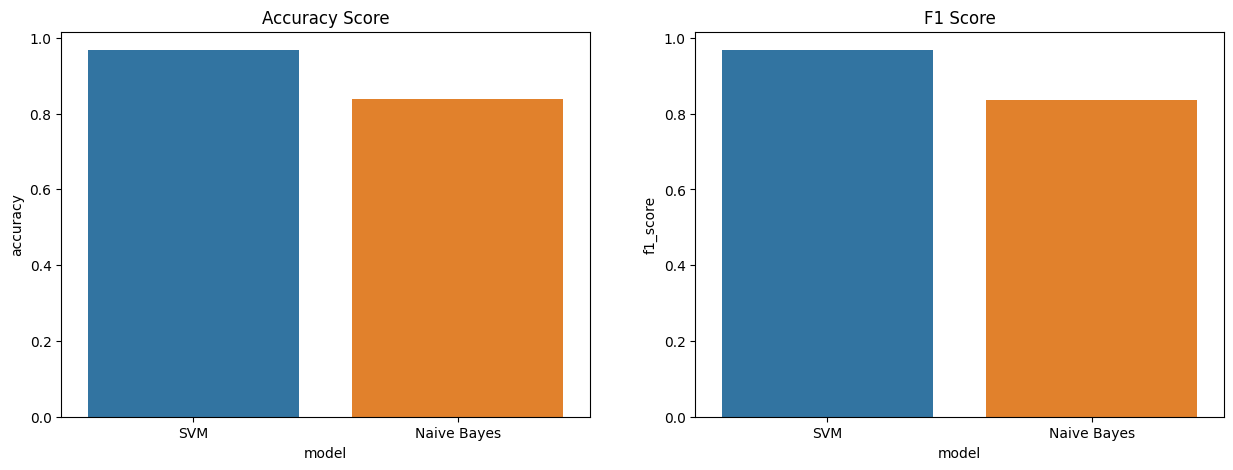

In [120]:
df = pd.DataFrame({'model': ['SVM', 'Naive Bayes'], 'accuracy': [accuracy_svc, accuracy_gb],
                   'f1_score': [f1_score_svm, f1_score_gb]})
# visualize model 
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(x='model', y='accuracy', data=df, ax=ax[0])
ax[0].set_title('Accuracy Score')
sns.barplot(x='model', y='f1_score', data=df, ax=ax[1])
ax[1].set_title('F1 Score')
plt.show();